# **Set Up**

In [ ]:
# import necessary libraries

import pandas as pd
import numpy as np
import os
import glob

# for modeling
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
import xgboost as xg
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg


# for scoring
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
file_path = '/content/gdrive/Shareddrives/Hackathon/Data localized/location'

# Helper functions

In [ ]:
def get_cartesian(lat=None,lon=None):
    '''
    Converts latitude and longitude arrays into (x,y,z) coordinates
    Input :
          latitude as array
          longitude as array
    Output :
          x,y,z cartesian coordinates
    '''
    # Change degrees to radians
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 1 # radius of the earth = 6371 km but not needed as we will normalize

    # Convert to cartesian
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)

    return x,y,z

def preprocess(file_path,final_test_set=False):
  '''
  Fetches files in a given path and preprocess them to return a feature matrix X (dataframe) and target values y (dataframe)
  Input :
        files: path as string
        final_test_set: a boolean that is used only for the final test set, because it requires semi colon and different processing for dates
  Outputs : 
        X : Feature matrix as DataFrame
        y : Target values as DataFrame
  '''
  #Fetch file names
  files = os.path.join(file_path, "*.csv")
  files = glob.glob(files)

  #Contatenate all files in one dataframe
  if final_test_set==False:
    df = pd.concat(map(pd.read_csv, files), ignore_index=True)
  else:
    df = pd.read_csv(file_path+'/test_set.csv',sep=";")

  # filter new apartment (in line with testset)
  df = df[(df['vefa']==1) & (df['libtypbien'].str.contains('APPARTEMENT'))]

  # filter out NaN values for 'valeurfonc' (14 lines)
  df = df[df['valeurfonc'].notnull()]

  # filter out the max value of valeurfonc which seems to be an outlier
  #df = df[df['valeurfonc']<22816956.0]

  # Process dates
  if final_test_set==False:
      df['datemut'] = pd.to_datetime(df['datemut'])
      df['day'] = df['datemut'].dt.day
      df['month'] = df['datemut'].dt.month
      df['year'] = df['datemut'].dt.year
      df.set_index('datemut', inplace=True)
  else:
      df['day'] = 1
      df['month'] = df['moismut']
      df['year'] = df['anneemut']


  # Only keep columns of interest
  #feature_columns = ['day','month','year','coddep','valeurfonc','sterr','nblocapt','nblocdep','nbapt1pp','nbapt2pp','nbapt3pp','nbapt4pp','nbapt5pp','sbatapt','sapt1pp','sapt2pp','sapt3pp','sapt4pp','sapt5pp','latitude','longitude']
  feature_columns = ['day','month','year','coddep','valeurfonc','nbapt1pp','nbapt2pp','nbapt3pp','nbapt4pp','nbapt5pp','sbatapt','latitude','longitude']  
  df = df[feature_columns]

  #One hot encoding of department
  df['coddep'] = df['coddep'].astype(int)
  y_df = df[['valeurfonc','coddep']]
  df = pd.get_dummies(df, columns=['coddep'])


  #Transform latitude and longitude in cartesian coordinates (x,y,z) (Earth as a 3D sphere and (0,0,0) its center)
  zone = df[['latitude','longitude']].to_numpy()
  x,y,z = get_cartesian(zone[:,0],zone[:,1])
  df= df.drop(['latitude','longitude'], axis=1)
  df['x'] = x
  df['y'] = y
  df['z'] = z

  #Split the target variable from the features
  #y_df = df['valeurfonc']
  df= df.drop(['valeurfonc'], axis=1)

  return df,y_df


def scores(y_true,y_pred, plot=False):
  '''
  Compute MAE, MSE, RMSE, R2 and MAPE scores and plot prediction errors
  Inputs :
        y_true : true target values
        y_pred : predictions
        plot: if True plots errors
  Outputs:
        A score dictionary containing the computed metrics
  '''
  #Compute MAE, MSE, RMSE, R2 and MAPE scores
  mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
  mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
  rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
  r2 = r2_score(y_true=y_true, y_pred=y_pred)
  mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
  error_ratio_rmse = rmse/np.mean(y_true)
  error_ratio_mae = mae/np.mean(y_true)

  # Plot the obtained errors and residuals if plot argument is set to True
  if plot:
      fig, axs = plt.subplots(ncols=2,figsize=(15,5))
      x = np.arange(np.amin(y_true),np.amax(y_true))
      axs[0].scatter(y_pred,y_true,label="actual_vs_predicted")
      axs[0].plot(x,x,color='black',linestyle='dashed')
      axs[0].set_title("Actual vs. Predicted values")
      axs[0].set_ylabel("Actual")
      axs[0].set_xlabel("Predicted")
      axs[1].scatter(y_pred,y_true-y_pred,label="residual_vs_predicted")
      axs[1].plot(x,[0]*len(x),color='black',linestyle='dashed')
      axs[1].set_title("Residuals vs. Predicted Values")
      axs[1].set_ylabel("Residuals (Actuals-Predictions)")
      axs[1].set_xlabel("Predicted")
      fig.suptitle("Prediction errors")
      plt.show()

  # Print the scores
  print(f'R²: {r2}')
  print(f'MAE: {mae}')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAPE: {mape}')
  print(f'error_ratio_rmse: {error_ratio_rmse}')
  print(f'error_ratio_mae: {error_ratio_mae}')

  #Return the scores in a dictionary
  scores = {
            'R2': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'error_ratio_rmse': error_ratio_rmse,
            'error_ratio_mae': error_ratio_mae,
            }

  return scores

# Preprocessing

In [ ]:
X_df, y_df = preprocess(file_path)

In [ ]:
X_df


## Split Train and Test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_df.to_numpy(), y_df['valeurfonc'].to_numpy(), test_size=0.20, random_state=100)

# Linear Regression

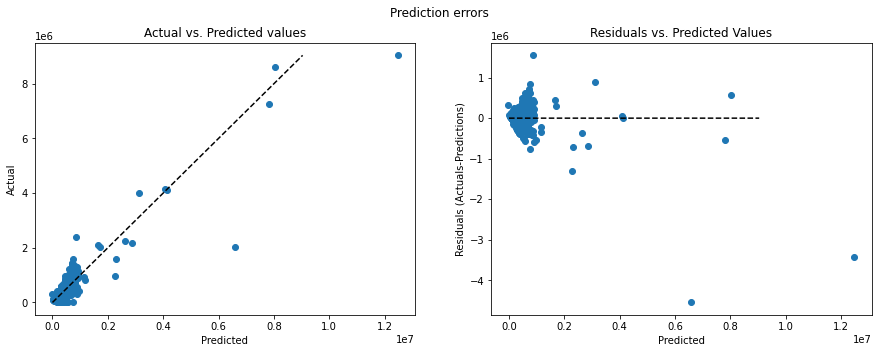

R²: 0.7977170294927889
MAE: 64080.55967978676
MSE: 18774584268.560555
RMSE: 137020.37902648115
MAPE: 97.6446213148097
error_ratio_rmse: 0.45867414666579454
error_ratio_mae: 0.21450893828948078


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
lin_reg_scores = scores(y_test,y_pred_lin_reg,plot=True)

In [ ]:
# cross_validation
cv_result = cross_validate(lin_reg, X_train, y_train,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error'))
pd.DataFrame(cv_result)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error
0,0.019731,0.009355,0.567191,-6.183763e+10,-72057.744985,-98.273783
1,0.029657,0.006221,0.611539,-2.555361e+10,-65526.910934,-0.429528
2,0.025906,0.004326,0.704568,-2.766568e+10,-67330.212840,-69.951068
3,0.036283,0.004305,0.836317,-2.860723e+10,-67784.867838,-45.208237
4,0.032443,0.006591,0.426251,-1.814475e+11,-74494.056604,-0.567549


# Lasso & Ridge

Penalization does not seem useful. The best alpha is always the lowest value in the given range for cross validation.

--- Lasso ---


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230162293296.375, tolerance: 221082785848.45926
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 609495226252.875, tolerance: 150751612599.79297
  model = cd_fast.enet_coordinate_descent_gram(


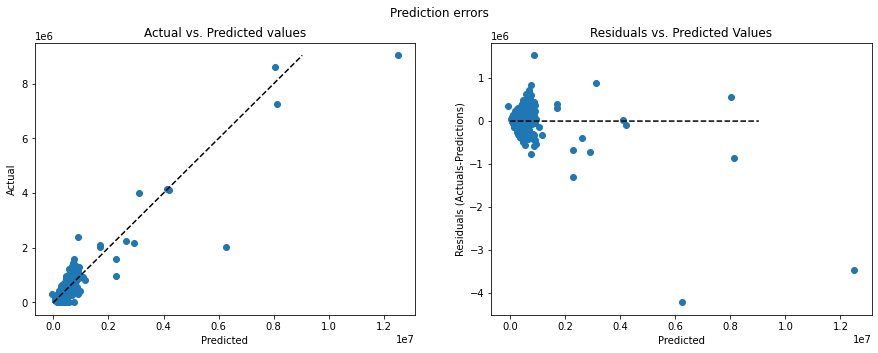

R²: 0.8033922291167694
MAE: 64101.17795976712
MSE: 18247849302.615765
RMSE: 135084.60053838766
MAPE: 92.88956539687976
error_ratio_rmse: 0.4521941503873673
error_ratio_mae: 0.21457795774514787
996.9314754300638
--- Ridge ---


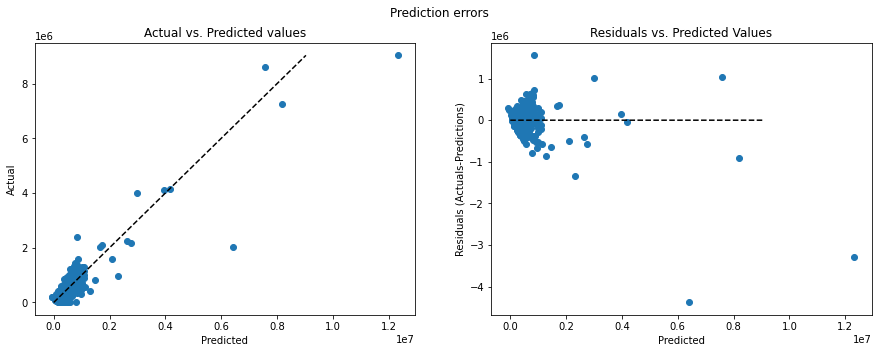

R²: 0.8006070513330144
MAE: 64617.58599539499
MSE: 18506351315.28108
RMSE: 136038.05098310206
MAPE: 90.03401942129112
error_ratio_rmse: 0.45538581481148177
error_ratio_mae: 0.21630662771932155
1e-05


In [ ]:
print('--- Lasso ---')
lasso = LassoCV(cv=5, alphas=np.random.default_rng().uniform(500,1000,100)).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
lasso_scores = scores(y_test,y_pred_lasso,plot=True)

print(lasso.alpha_)

print('--- Ridge ---')
ridge = RidgeCV(alphas=(0.001,0.01,0.1,1,0.00001),cv=5).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
ridge_scores = scores(y_test,y_pred_ridge,plot=True)

print(ridge.alpha_)

# Robust Regression

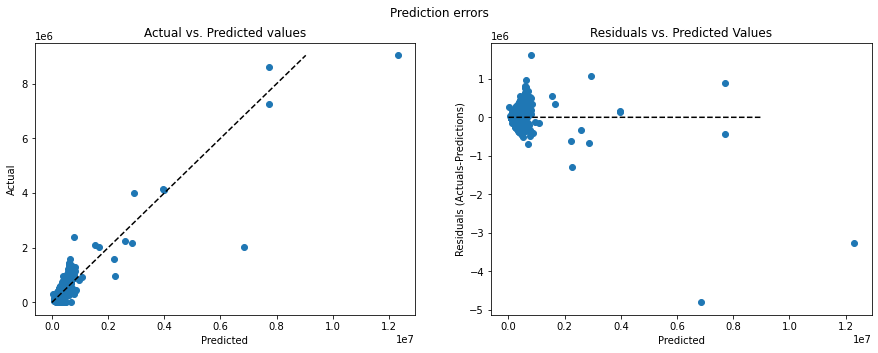

R²: 0.7838022976600859
MAE: 62977.831828853756
MSE: 20066058804.021717
RMSE: 141654.71684353374
MAPE: 88.51796157236788
error_ratio_rmse: 0.47418753933555796
error_ratio_mae: 0.21081756946080787


In [ ]:
huber = HuberRegressor(epsilon=1.35, max_iter=10000, alpha=0.0001).fit(X_train,y_train)
y_pred_huber = huber.predict(X_test)
huber_scores=scores(y_test,y_pred_huber,plot=True)

In [ ]:
# cross_validation
cv_result = cross_validate(huber, X_train, y_train,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error'))
pd.DataFrame(cv_result)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error
0,1.818743,0.001972,0.565844,-6.203008e+10,-70938.521500,-96.836343
1,3.279751,0.001709,0.718841,-1.849509e+10,-60897.600028,-0.390469
2,6.061383,0.002388,0.710558,-2.710475e+10,-65269.113496,-69.044548
3,2.748230,0.001728,0.823702,-3.081186e+10,-66312.695797,-41.223008
4,2.640672,0.001785,0.427532,-1.810421e+11,-72969.531041,-0.508864


# Random Forest

In [ ]:
# Training
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 12, random_state = 18).fit(X_train, y_train)

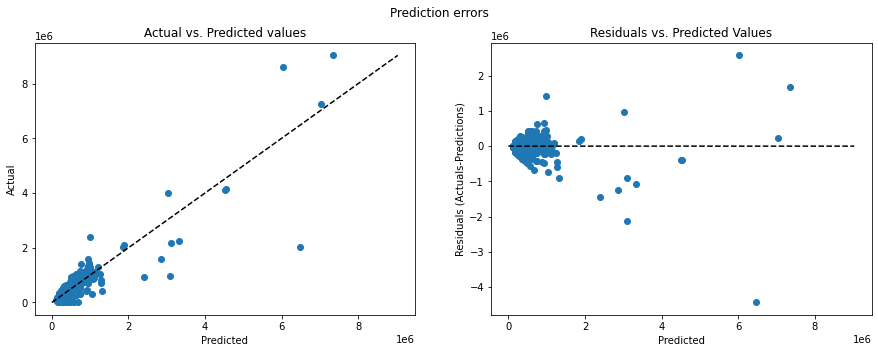

R²: 0.8221998553106336
MAE: 49105.67717167906
MSE: 16502248266.686243
RMSE: 128461.07685476656
MAPE: 91.58039183269081
error_ratio_rmse: 0.4300219808525097
error_ratio_mae: 0.16438069091031263


In [ ]:
y_pred_random_forest = rf.predict(X_test)
random_forest_scores=scores(y_test,y_pred_random_forest,plot=True)

In [ ]:
# cross_validation
cv_result = cross_validate(rf, X_train, y_train,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error'))
pd.DataFrame(cv_result)

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error
0,3.998287,0.188165,0.629363,-5.295480e+10,-56218.552497,-95.148204
1,4.206105,0.139403,0.790189,-1.380170e+10,-47965.223069,-0.362782
2,3.453688,0.147051,0.770190,-2.152046e+10,-50630.493633,-67.039826
3,3.371896,0.152071,0.801798,-3.464007e+10,-53462.589886,-55.638146
4,4.711374,0.177037,0.438789,-1.774820e+11,-58668.672321,-0.474525



# XGBOOST

In [ ]:
# Before tuning
#xgb = xg.XGBRegressor(n_estimators=1000, learning_rate=0.01).fit(X_train, y_train)
# After hyper-parameter tuning using bayesian search(see below blocks)
xgb = xg.XGBRegressor(n_estimators=180, colsample_bytree=0.534145326940449, gamma=1.013878917680906, max_depth=18, min_child_weight=1, reg_alpha=58, reg_lambda=0.8886087308195848, seed=0).fit(X_train, y_train)

#xgb = xg.XGBRegressor(n_estimators=258, colsample_bytree=0.8989653194310321, gamma=1.013878917680906, max_depth=18, min_child_weight=1, reg_alpha=58, reg_lambda=0.8886087308195848, seed=0).fit(X_train, y_train)


[16:16:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


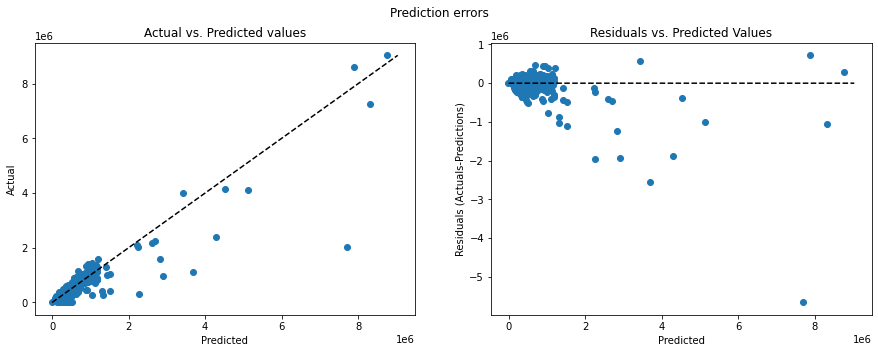

R²: 0.8102382773612692
MAE: 33196.175585081866
MSE: 17612443814.20166
RMSE: 132711.8827166643
MAPE: 131.7178461632696
error_ratio_rmse: 0.4442515047029078
error_ratio_mae: 0.11112381688940315


In [ ]:
y_pred_xgb = xgb.predict(X_test)
xgb_scores=scores(y_test,y_pred_xgb,plot= True)

In [ ]:
# cross_validation
cv_result = cross_validate(xgb, X_train, y_train,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error'))
pd.DataFrame(cv_result)

[16:22:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error
0,9.182062,0.286339,0.594949,-5.787167e+10,-41697.188609,-98.938106
1,8.092256,0.378816,0.806833,-1.270683e+10,-33054.606851,-0.277500
2,8.814018,0.297995,0.732998,-2.500333e+10,-37797.046788,-64.688450
3,11.166458,0.613997,0.809476,-3.329823e+10,-40107.629575,-54.580971
4,17.099588,0.479931,0.457114,-1.716870e+11,-43419.445640,-0.368673


### Hyper-parameters tuning


In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 40, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,280,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,150),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 400, 1),
        'seed': hp.quniform('seed', 0, 400, 1)
    }

In [ ]:
def objective(space):
    clf=xg.XGBRegressor(
                          n_estimators =int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          gamma = space['gamma'],
                          reg_alpha = space['reg_alpha'],
                          reg_lambda = space['reg_lambda'],
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=space['colsample_bytree'],
                          seed = int(space['seed'])
                       )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = clf.predict(X_test)
    score = scores(y_test,y_pred)['RMSE']
    print ("SCORE:", score)
    return {'loss': score, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

[15:34:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R²: 0.6769577673035052
MAE: 63914.121121209486
MSE: 29982670339.755974
RMSE: 173155.0471102589
MAPE: 130.90858844727012
error_ratio_rmse: 0.5796345334793159
error_ratio_mae: 0.21395178712430293
SCORE:
173155.0471102589
[15:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R²: 0.7339456081790356
MAE: 59753.74210955306
MSE: 24693431121.45595
RMSE: 157141.43667873205
MAPE: 161.09862511477453
error_ratio_rmse: 0.5260291562945141
error_ratio_mae: 0.2000249661175606
SCORE:
157141.43667873205
[15:34:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R²: 0.7667232116216061
MAE: 53537.93590121708
MSE: 21651228031.34431
RMSE: 147143.5626568295
MAPE: 177.01549663589165
error_ratio_rmse: 0.4925613877184105
error_ratio_mae: 0.17921762

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

best_h = pd.DataFrame.from_dict([best_hyperparams]) 
best_h.to_csv ('/content/gdrive/Shareddrives/Hackathon/best_hyperparameters_xgboost5.csv', index=False, header=True)

The best hyperparameters are :  

{'colsample_bytree': 0.9296528884800502, 'gamma': 4.648922228806588, 'max_depth': 22.0, 'min_child_weight': 0.0, 'n_estimators': 318.0, 'reg_alpha': 219.0, 'reg_lambda': 29.488760478841048, 'seed': 324.0}


[16:31:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


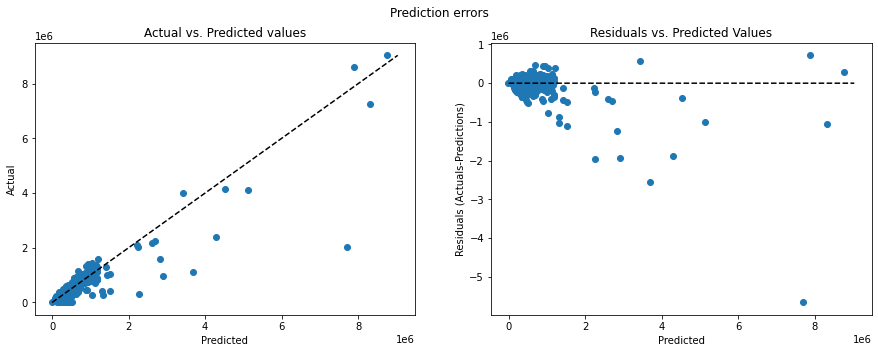

R²: 0.8102382773612692
MAE: 33196.175585081866
MSE: 17612443814.20166
RMSE: 132711.8827166643
MAPE: 131.7178461632696
error_ratio_rmse: 0.4442515047029078
error_ratio_mae: 0.11112381688940315


In [ ]:
best_hyperparams ={'colsample_bytree':0.534145326940449, 'gamma':1.013878917680906, 'max_depth':18, 'min_child_weight':1,'n_estimators':180, 'reg_alpha':58, 'reg_lambda':0.8886087308195848, 'seed':0}


xgb_tuned = xg.XGBRegressor(
                          n_estimators =int(best_hyperparams['n_estimators']), 
                          max_depth = int(best_hyperparams['max_depth']), 
                          gamma = best_hyperparams['gamma'],
                          reg_alpha = best_hyperparams['reg_alpha'],
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=best_hyperparams['colsample_bytree'],
                          seed = int(best_hyperparams['seed'])
                       )
evaluation = [( X_train, y_train), ( X_test, y_test)]

xgb_tuned.fit(X_train, y_train)#,eval_set=evaluation, eval_metric="rmse",early_stopping_rounds=10,verbose=False)

y_pred = xgb_tuned.predict(X_test)
score = scores(y_test,y_pred,plot=True)

# Gradient Boosting (sklearn)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


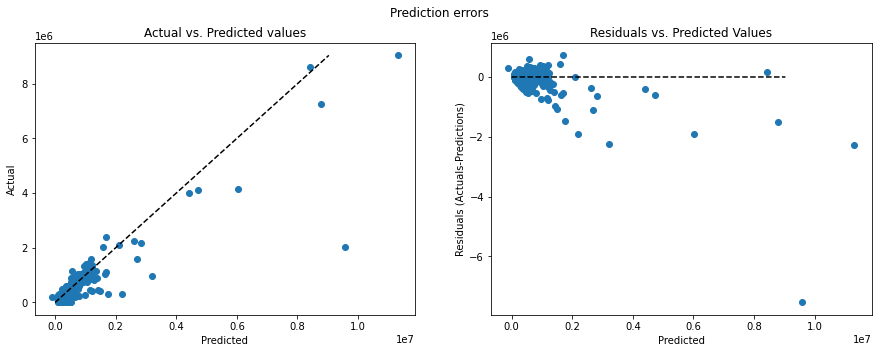

R²: 0.72971727029985
MAE: 38910.76953436158
MSE: 25085877829.30123
RMSE: 158385.2197312023
MAPE: 123.43393453706838
error_ratio_rmse: 0.5301927057919134
error_ratio_mae: 0.1302533545673044


In [ ]:
gdb = GradientBoostingRegressor(n_estimators = 300, max_depth = 5, min_samples_split = 2, learning_rate = 0.1, loss = 'ls')
gdb.fit(X_train, y_train)
y_pred = gdb.predict(X_test)
gdb_scores=scores(y_test, y_pred, plot= True)

In [ ]:
# cross_validation
cv_result = cross_validate(gdb, X_train, y_train,scoring=('r2', 'neg_mean_squared_error','neg_mean_absolute_error','neg_mean_absolute_percentage_error'))
pd.DataFrame(cv_result)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in v

,fit_time,score_time,test_r2,test_neg_mean_squared_error,test_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error
0,11.075737,0.030099,0.591553,-5.835689e+10,-46456.774255,-87.930947
1,8.898239,0.022966,0.808363,-1.260623e+10,-36460.661467,-0.307238
2,11.135779,0.030369,0.792687,-1.941381e+10,-40429.717189,-58.468381
3,12.880166,0.022014,0.829286,-2.983591e+10,-40964.789651,-55.351898
4,10.106467,0.021926,0.464577,-1.693267e+11,-45340.210434,-0.400786


# Test

In [ ]:
X_true_test, y_true_test = preprocess('/content/gdrive/Shareddrives/Hackathon/Data localized/',final_test_set=True)
y_true_test = y_true_test['valeurfonc'].to_numpy()
X_true_test = X_true_test.to_numpy()

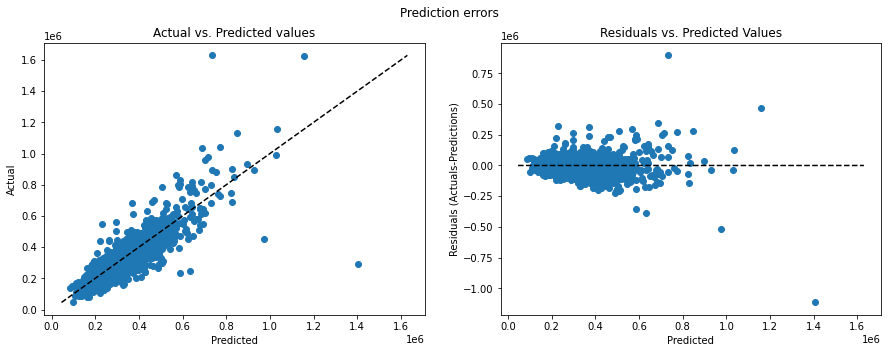

R²: 0.7740790242351437
MAE: 35416.97924173292
MSE: 3537938293.2647877
RMSE: 59480.570720738615
MAPE: 0.1357715942061789
error_ratio_rmse: 0.2241448807001491
error_ratio_mae: 0.13346433113712572


In [ ]:
y_pred =xgb.predict(X_true_test)
xgb_final_scores=scores(y_true_test, y_pred, plot= True)

In [ ]:
# save model to JSON and load it
xgb.save_model("model.json")

# To load model
# xgb_2 = XGBRegressor()
# xgb_2.load_model("model.json")

# Time-Series

In [ ]:
departments = [75,77,78,91,92,93,94,95]
dict_series = {dept : y_df[y_df['coddep']==dept]['valeurfonc'] for dept in departments}

def compute_seasonal_means(dict_series):
    '''
    This function compute seasonal means to account for the seasonality component.
    '''
    # Transform dict series
    dict_series = dict_series.sort_index()
    dict_series = dict_series.resample('M').mean()

    # Copy initial time series and change it to dataframe
    df=dict_series.to_frame().copy()

    # add month column and interpolate missing values
    df['date'] = df.index.to_series()
    df['month'] = df['date'].dt.month                            #range:  1-12
    df['valeurfonc'].interpolate(method='linear',inplace=True)

    #Compute seasonal monthly average
    dmean=df.groupby("month").valeurfonc.mean().to_frame()
    dmean.rename(columns={'valeurfonc':'dmu_m'},inplace=True)
    df=df.merge(dmean,how="inner",on='month')

    # Sort the dataframe by dates
    df.sort_values(by='date',ascending=True,inplace=True)

    # Compute the residuals
    df['residuals_add']= df['valeurfonc']-df['dmu_m']
    df['residuals_mult']= df['valeurfonc']/df['dmu_m']
    return df

def plot_basic(df):
    '''
    Basic plots
    '''
    # Box plot
    plt.figure()
    df.to_frame().boxplot()

    # Time series plot
    plt.figure()
    df.plot()

def plot_residuals(df,restype = 'mul',title=''):
    '''
    This function plots the residuals 
    '''
    # Whether to use multiplicative of additive residuals
    if restype != 'mul':
        colname = 'residuals_add'
    else:
        colname = 'residuals_mult'

    # Plot time series of residuals
    plt.figure()
    plt.plot(df['date'],df[colname])
    plt.title("residuals - "+str(title))

    # Plot ACF
    plt.figure()
    sm.graphics.tsa.plot_acf(df[colname], lags=np.arange(10))
    plt.title("ACF - "+str(title))

    # Plot PACF
    plt.figure()
    sm.graphics.tsa.plot_pacf(df[colname], lags=np.arange(10),method='ywm')
    plt.title("PACF - "+str(title))

#**Residuals modelling**



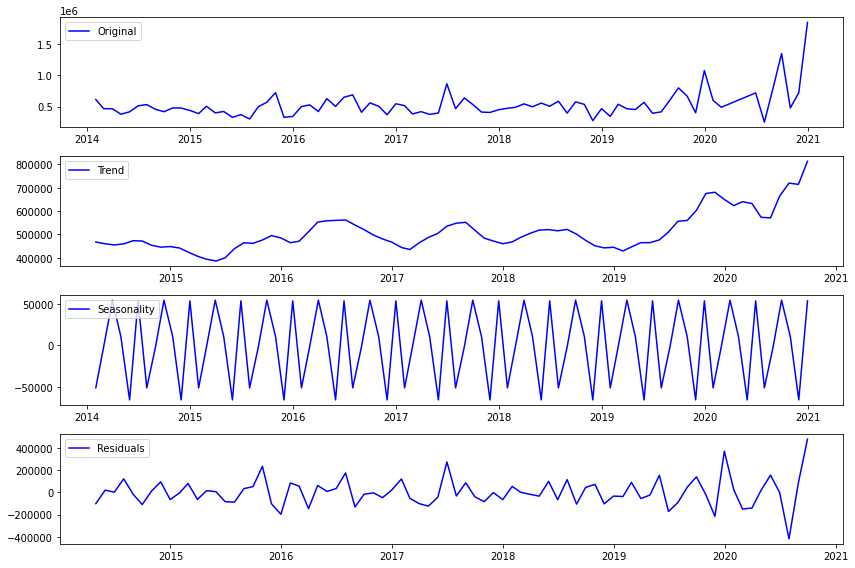

In [ ]:
series = dict_series[75].sort_index().resample('M').mean().to_frame()
series['valeurfonc'].interpolate(method='linear',inplace=True)
decomposition = sm.tsa.seasonal_decompose(series['valeurfonc'], model='additive', period=6)

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(series['valeurfonc'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

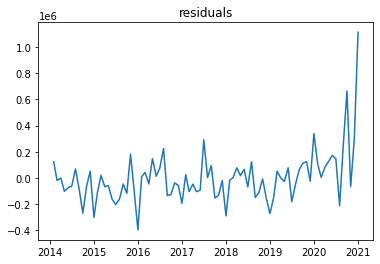

<Figure size 432x288 with 0 Axes>

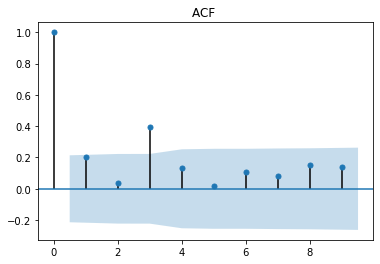

<Figure size 432x288 with 0 Axes>

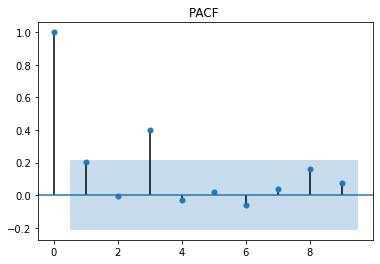

In [ ]:
df_series = compute_seasonal_means(dict_series[75])
plot_residuals(df_series,restype='add')

<ipython-input-296-f932e0b333d8>:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-296-f932e0b333d8>:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figu

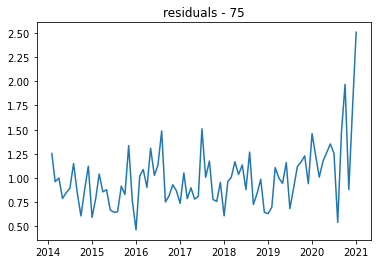

<Figure size 432x288 with 0 Axes>

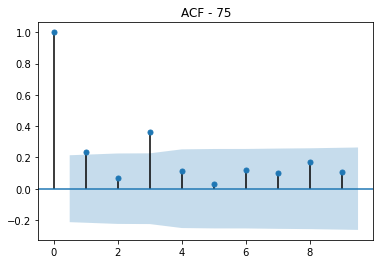

<Figure size 432x288 with 0 Axes>

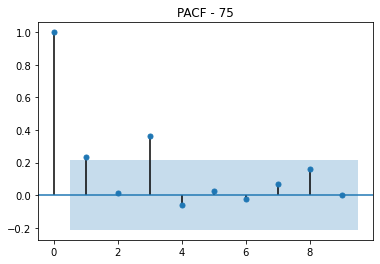

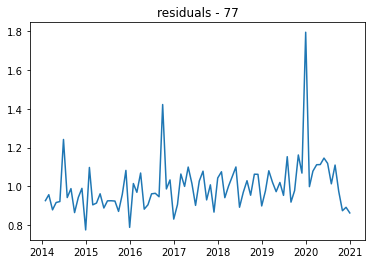

<Figure size 432x288 with 0 Axes>

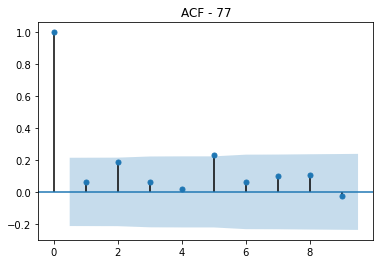

<Figure size 432x288 with 0 Axes>

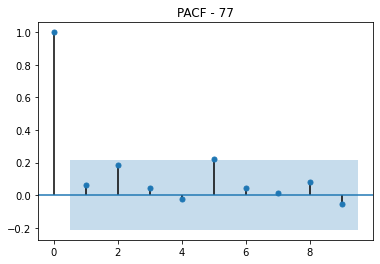

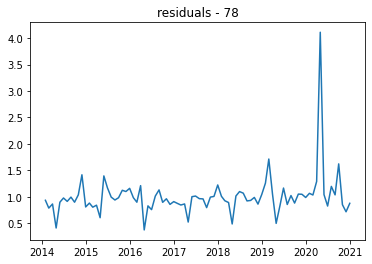

<Figure size 432x288 with 0 Axes>

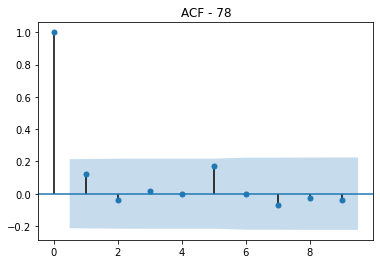

<Figure size 432x288 with 0 Axes>

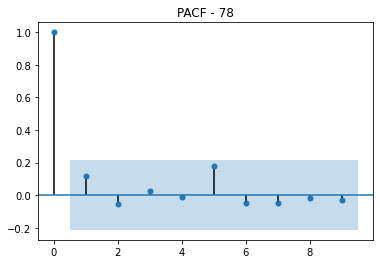

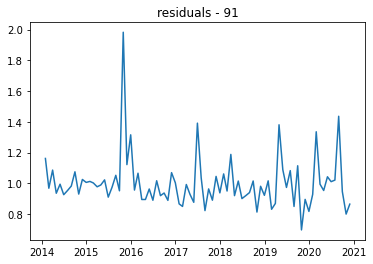

<Figure size 432x288 with 0 Axes>

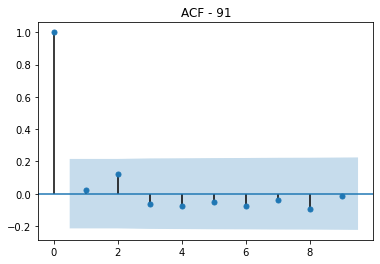

<Figure size 432x288 with 0 Axes>

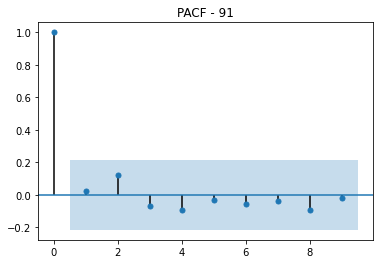

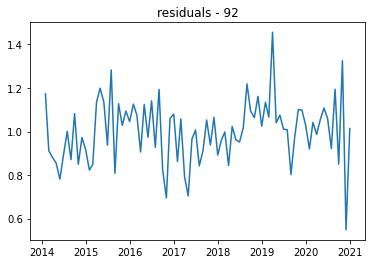

<Figure size 432x288 with 0 Axes>

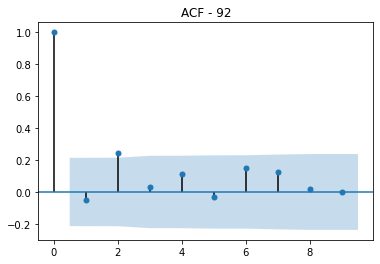

<Figure size 432x288 with 0 Axes>

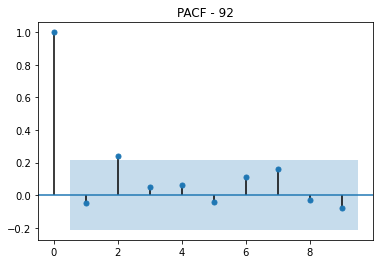

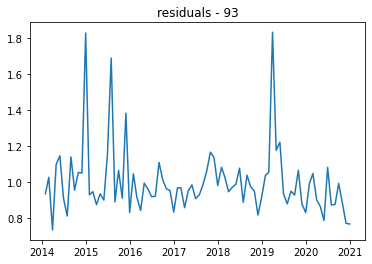

<Figure size 432x288 with 0 Axes>

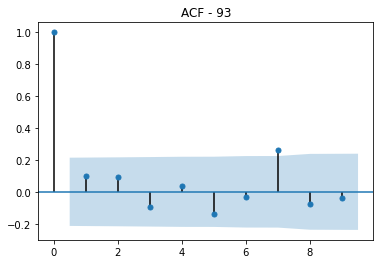

<Figure size 432x288 with 0 Axes>

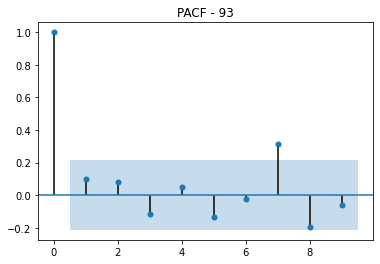

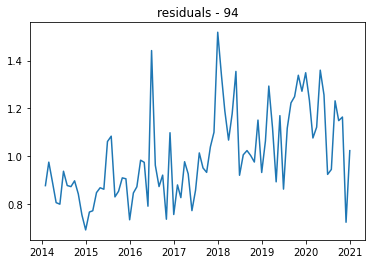

<Figure size 432x288 with 0 Axes>

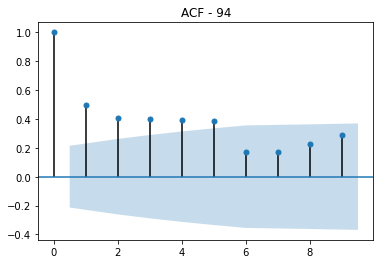

<Figure size 432x288 with 0 Axes>

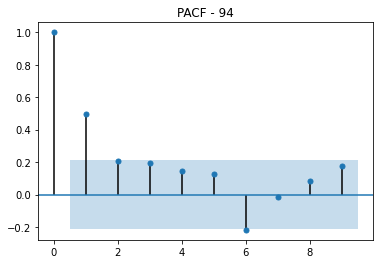

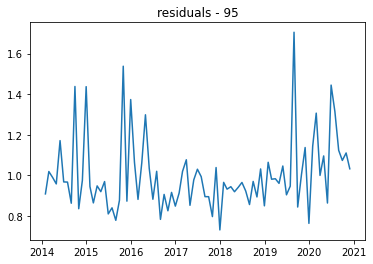

<Figure size 432x288 with 0 Axes>

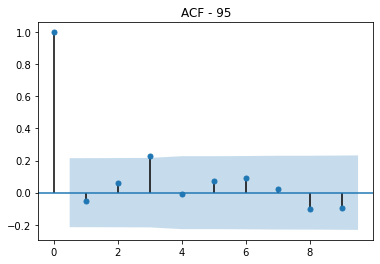

<Figure size 432x288 with 0 Axes>

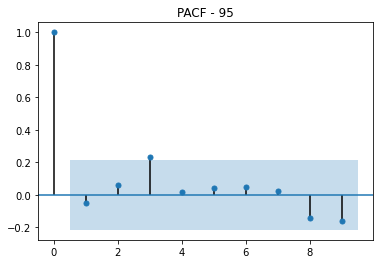

In [ ]:
for dept in departments:
  df_series = compute_seasonal_means(dict_series[dept])
  plot_residuals(df_series, title = dept)

,valeurfonc,date,month,dmu_m,residuals_add,residuals_mult
0,6.128672e+05,2014-01-31,1,488943.179881,1.239240e+05,1.253453
7,4.652571e+05,2014-02-28,2,483876.359594,-1.861928e+04,0.961521
14,4.642579e+05,2014-03-31,3,464478.674041,-2.207715e+02,0.999525
21,3.769043e+05,2014-04-30,4,478351.135105,-1.014468e+05,0.787924
28,4.150000e+05,2014-05-31,5,489123.669643,-7.412367e+04,0.848456
...,...,...,...,...,...,...
55,8.000000e+05,2020-08-31,8,542620.408163,2.573796e+05,1.474327
62,1.350000e+06,2020-09-30,9,685676.446499,6.643236e+05,1.968859
69,4.770000e+05,2020-10-31,10,541953.733425,-6.495373e+04,0.880149
76,7.200000e+05,2020-11-30,11,423929.480825,2.960705e+05,1.698396


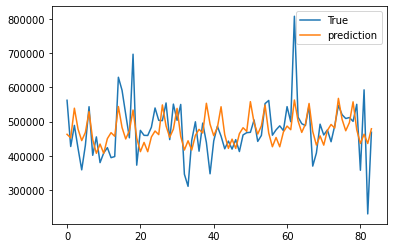

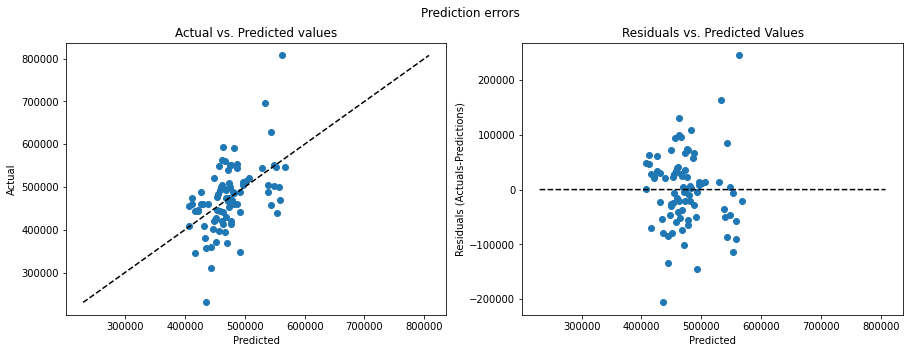

R²: 0.26188613928421745
MAE: 51720.94044196925
MSE: 4691784335.882785
RMSE: 68496.60090751063
MAPE: 0.1153432248093574
error_ratio_rmse: 0.1444163389023652
error_ratio_mae: 0.10904700035118772


(array([399.37365979]), 485802.0899157269)

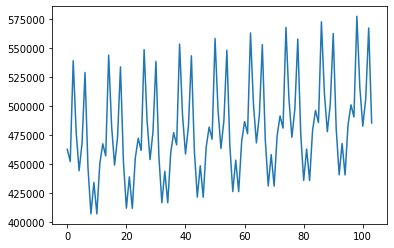

In [ ]:
df_series = compute_seasonal_means(dict_series[92])
y_true_series = df_series['valeurfonc'].to_numpy()
y_residuals_series = df_series['residuals_add'].to_numpy()
seasonal_series = df_series['dmu_m'].to_numpy()
horizon = np.arange(len(df_series['residuals_add'].to_numpy()))

lin_reg_time_series = LinearRegression()
lin_reg_time_series.fit(horizon.reshape(-1, 1), y_residuals_series)
y_series_pred = seasonal_series+lin_reg_time_series.predict(horizon.reshape(-1, 1))

plt.plot(horizon,y_true_series, label = "True")
plt.plot(horizon,y_series_pred, label = "prediction")
plt.legend()

scores(y_true_series, y_series_pred,plot=True)

prediction_horizon = len(horizon + 12)
# plt.figure()
# plt.plot(seasonal_series+lin_reg_time_series.predict(np.arange(len(horizon)+ 20).reshape(-1, 1)))

u = list(seasonal_series[:12])
v= []
for i in range((len(horizon)+20)//12 + 1):
  v.append(u) 

seas = np.array(v).flatten()[:(len(horizon)+20)]

plt.figure()
plt.plot(seas+lin_reg_time_series.predict(np.arange(len(horizon)+ 20).reshape(-1, 1)))



df_series = compute_seasonal_means(dict_series[92])

def project_horizon(df_series, horizon):
    y_true_series = df_series['valeurfonc'].to_numpy()
    y_residuals_series = df_series['residuals_add'].to_numpy()
    seasonal_series = df_series['dmu_m'].to_numpy()
    timeline = np.arange(len(df_series['residuals_add'].to_numpy()))

    lin_reg_time_series = LinearRegression()
    lin_reg_time_series.fit(timeline.reshape(-1, 1), y_residuals_series)
    y_series_pred = seasonal_series+lin_reg_time_series.predict(timeline.reshape(-1, 1))

    prediction_horizon = len(timeline) + horizon

    months_means = list(seasonal_series[:12])
    projected_seasonal_component= []
    for i in range(prediction_horizon//12 + 1):
      projected_seasonal_component.append(months_means) 

    projected_seasonal_component = np.array(projected_seasonal_component).flatten()[:prediction_horizon][-1]
    projected_trend = lin_reg_time_series.predict(np.arange(prediction_horizon).reshape(-1, 1))[-1]
    

    return lin_reg_time_series.coef_,projected_seasonal_component+projected_trend

project_horizon(df_series,2)


In [ ]:
for dept in departments:
    df_series = compute_seasonal_means(dict_series[dept])
    timeline = np.arange(len(df_series['residuals_add'].to_numpy()))
    last_month= df_series['month'].to_numpy()[-1]
    print("if dept==",dept,":  seasonal = ",list(df_series['dmu_m'].to_numpy()[:12]))

if dept== 75 :  seasonal =  [488943.17988095235, 483876.35959415586, 464478.67404135346, 478351.13510513294, 489123.66964285716, 572904.6044727891, 462084.07845238096, 542620.4081632653, 685676.4464985995, 541953.7334254318, 423929.48082482995, 737492.7262347427]
if dept== 77 :  seasonal =  [210909.60653740572, 208387.31866943176, 215018.5221276747, 214013.48943169127, 206943.92926208032, 227955.3601790199, 214236.4466901606, 211133.23499294528, 226261.6728538389, 196002.70675190407, 211506.34738734722, 243367.5458287634]
if dept== 78 :  seasonal =  [272139.2926330669, 300936.7156997677, 301996.77667320246, 585694.5305625258, 287993.33945238095, 269349.40191789006, 285598.5092062163, 273219.40744357515, 309498.72995663265, 260537.420491354, 304129.8555823272, 299539.392464178]
if dept== 91 :  seasonal =  [214935.31628680142, 221444.51990806017, 203555.1897128548, 227201.27833363487, 221352.94386355553, 228306.52669651803, 215665.3283720344, 224491.35798191093, 217815.4758737916, 237354

In [ ]:
for dept in departments:
    df_series = compute_seasonal_means(dict_series[dept])
    coef,_ =  project_horizon(df_series,2)
    print("if dept==",dept,":  slope = ",coef[0])

if dept== 75 :  slope =  3149.3235209600575
if dept== 77 :  slope =  354.0234148653532
if dept== 78 :  slope =  1885.3054545099722
if dept== 91 :  slope =  -130.8133202213942
if dept== 92 :  slope =  399.3736597875623
if dept== 93 :  slope =  -338.88537593816545
if dept== 94 :  slope =  1381.8819732699967
if dept== 95 :  slope =  215.19541104031566
